# Particle Swarm Optimization Tutorial

This is a tutorial to implement a particle swarm optimization (PSO) algorithm using continuous numerical data. There are a few ways to approach an implementation of PSO but the most basic involves particles in a two-dimensional space--what this tutorial will implement. Feel free to distribute, edit, make changes, improve, etc. this tutorial. If you publish this tutorial elsewhere, please let me know and link back.

## Particle Swarms

PSO is a type of artificial intelligence algorithm which is inspired by behavior of flocks of birds. PSO falls broadly under the spectrum of swarm intelligence algorithms which include others like bee colony optimization, ant colony optimization, and so on.

The goal of PSO is to optimize a set of solutions to a problem based on some fitness function. By encoding solutions as particles or point in `n`-space with a value for position and velocity, the swarm particles can reposition themselves to be closer to an optimization problem optima based on the fitness of the swarm and individual particles within the swarm. Given an initial random population (swarm) of solutions (particles) to the problem, members of the swarm will eventually converge to a global optima provided parameters are appropriate.

To perform PSO, you need to know a few things things:

- what is the search space?
- what is the fitness function?
- what are the PSO parameters?

The search space being the possible space in which the solution lies and the fitness function being a heuristic to gauge how fit a solution is. There are three PSO parameters of import: inertial weight (denoted by $\omega$), which is the resistance to a change in particle velocity; the cognitive coefficient (denoted by $c_1$), which allows for global exploration and local exploitation; and the social coefficient (denoted by $c_2$), which is for global exploitation and local exploration. Exploration means searching within a specific area and exploitation is focusing on promising areas as found from exploration.

PSO is commonly referred to as a metaheuristic, or a procedure which generates a solution to an optimization problem. It's not guaranteed to be optimal, but it is a more "informed" search than random. Given the search space and fitness function, the algorithms generates generally good solution. Metaheuristics can be used problem agnostic and can be applied to almost anything. One interesting way to use PSO is to train a neural network.

Just as a note on terminology, I say "solution", "candidate", "particle" interchangeably: they mean the same thing and is just a possible solution to the problem being optimized. The most proper term would be "particle".

## Pseudocode

A typical PSO algorithm may follow the below pseudocode:

```
procedure pso() is:
  initialize random swarm s of particles
  for each epoch do:
    for each particle p in swarm s do:
      for each dimension d in search space do:
        new_vel, new_pos = [], []
        new_vel[d] := w * p.vel
        new_vel[d] += c1 * r1 * (p.best_pos[d] - p.pos[d])
        new_vel[d] += c2 * r2 * (s.best_pos[d] - p.pos[d])
        new_pos[d] := p.pos[d] + new_vel[d]
      endfor
      p.vel = new_vel
      p.pos = new_pos
    endfor
    for each particle p in swarm s do:
      if fitness(p.pos) < p.fit do:
        p.fit := fitness(p.pos)
      endif
    endfor
    update swarm best
    update particle bests
  endfor
endprocedure
```

## Before you Begin

This tutorial uses Python with one dependency which needs to be met:

- Python 3.6
- GNU/Linux (or WSL, LXSS, etc)
- X11 or alternative
- `matplotlib`

You can install `matplotlib` using `pip` although it's not entirely necessary to have `matplotlib` as it's only for illustrative purposes for this tutorial. It can be omitted if desired.

## Defining the Search Space and Fitness Function

This tutorial will use a common optimization test problem, the Schwefel Function, which is defined as:

$$f(x) = 418.9829 \times d - \sum_{i=1}^d (x_i \times \sin{\sqrt{|x_i|}})$$

And can be visualized in two dimensions as below:

<img src="./images/schwefel.png"/>

This function can be applied to any dimensionality and has a global minimum of $f(x^*) = 0$ at $x^* = (420.9687, ..., 420.9687)$. For this tutorial, I'll be using a dimensionality of two to best visualize on a 2D plot. We can see this in a map:

<img src="./images/schwefel-map.png"/>

Note the darkest blue region is around the global optima. This function was chosen specifically because it has many local minimum, something PSO excels at escaping. The `gnuplot` code to generate both can of these images can be found in `/code`.

We have the fitness function, what about the search space? The interval in which our particles will reside is `[-500, 500]`. We'll use this information to also generate a swarm later. We wish to initialize a random swarm within these bounds as this is our search space. Particles in our swarm will be described as arrays of length `d`, where `d` is the dimensionality of the problem--in this case, two.

We'll define the search space and fitness function now:

In [1]:
from math import sin, sqrt

SEARCH_MIN = -500 # minimum in search space
SEARCH_MAX = 500 # maximum in search space
DIMENSIONS = 2 # dimensionality of the problem

def schwefel(particle):
    """PSO fitness function.
    Uses Schwefel function in d dimensions.
    
    Parameters:
        particle : a particle in d-space.
    
    Returns:
        The fitness of that particle.
    """
    summ = 0
    for d in particle:
        summ += d * sin(sqrt(abs(d)))
    return (len(particle) * 418.9829) - summ

Just to verify the function is working as intended, we'll generate a "perfect particle" with the known optimal position and evaluate its fitness:

In [2]:
OPTIMAL_PARTICLE = [420.9687 for _ in range(DIMENSIONS)]
print(schwefel(OPTIMAL_PARTICLE))

2.545567497236334e-05


This is not exact but $2.55\times10^{-5}$ is arbitrarily close to the optima $0$, close enough for our purposes. We know our global minimum is around this point at the very least. We've initialized this as a global variable because soon we'll want to see where the minimum is in our plots.

## Particle Representation

Particles with be represented as a position in each dimension as well as a velocity in each dimension. To do this, we'll make a Particle class to store this information. We also need a way to store a particle's previous best position, its current fitness, and best fitness.

In [3]:
class Particle:
    """Particle class.
    Containzerizes a position, velocity.
    
    Attributes:
        pos : the position in n-space.
        best_pos : the best position this particle has had.
        fit : the fitness of the particle.
        best_fit : the best fitness this particle has had.
        vel : the velocity in n-space.
    """
    
    def __init__(self, pos, vel):
        """Particle constructor."""
        # initialize position and velocity as params
        self.pos, self.vel = pos, vel
        # find fitness at instantiation
        self.fit = schwefel(self.pos)
        # best so far is just initial
        self.best_pos, self.best_fit = self.pos, self.fit
    
    def set_pos(self, pos):
        """Position mutator method."""
        self.pos = pos
        # get fitness of new position if the new
        # position is still within the search
        # space. Otherwise don't update fitness
        if not any(p < SEARCH_MIN for p in pos)\
        and not any(p > SEARCH_MAX for p in pos):
            # get the fitness
            fitness = schwefel(self.pos)
            # if better
            if fitness < self.best_fit:
                self.fit = fitness
                # update best fitness
                self.best_fit = self.fit
                # update best position
                self.best_pos = self.pos
    
    def set_vel(self, vel):
        """Velocity mutator method."""
        self.vel = vel
    
    def get_pos(self):
        """Position accessor method."""
        return self.pos
    
    def get_vel(self):
        """Velocity accessor method."""
        return self.vel
    
    def get_best_pos(self):
        """Best position accessor method."""
        return self.best_pos

    def get_fit(self):
        """Fitness accessor method."""
        return self.fit
    
    def get_best_fit(self):
        """Best fitness accessor method."""
        return self.best_fit

Since we now how how particles are represented, we can make a swarm of them.

## Swarm Initialization

First, we need to initialize an initial swarm. Since we know the search space boundaries, our swarm consists of particles in `2`-space where each axis is randomized within the bounds of the search space. Recall a particle is just an encoding of some solution to the problem: our solutions are in two dimensions so particles are also in two dimensions. Additionally, we'll start with a swarm size of `200`:

In [4]:
import random

SWARM_SIZE = 200 # how large our swarm is

def initialize_swarm(size, dim, min, max):
    """Swarm initialization function.
    
    Parameters:
        size : the size of our swarm.
        dim : the dimensionality of the problem.
        min : the minimum in a dimension for the search space.
        max : the maximum in a dimension for the search space.
    
    Returns:
        A random swarm of that many Particles within the bounds of the space.
    """
    swarm = [] # swarm stored as list
    for _ in range(size): # for the size of the swarm
        # position is random in every dimension
        position = [random.uniform(min, max) for _ in range(dim)]
        # velocity is initially zero in every dimension
        velocity = [0 for _ in range(dim)]
        # init a particle
        particle = Particle(position, velocity)
        swarm.append(particle) # add to swarm
    return swarm

SWARM = initialize_swarm(SWARM_SIZE, DIMENSIONS, SEARCH_MIN, SEARCH_MAX)

To show our initialization is correct, we'll print out a few particles and examine their positions and fitnesses:

In [5]:
random.shuffle(SWARM)
for i in range(5):
    print(SWARM[i].get_pos(), "=", SWARM[i].get_fit())

[132.1122095054567, -345.59243830350596] = 865.3464638614537
[-323.7980888932579, -102.02603846134105] = 529.7653393000207
[106.30303354933301, -184.30057325146873] = 1076.2821135584174
[135.7042670571525, 169.92525193245137] = 868.8671987423096
[61.69931779065473, -420.4552134169011] = 1195.2161254015616


Here we can see our particles are in two dimensions and each axis is within the bounds of `[-500, 500]`. We'll be using `matplotlib` to plot these to see where particles lay within the search space. We've chosen to do this in two dimensions as it is difficult to visualize on a 2D plot otherwise.

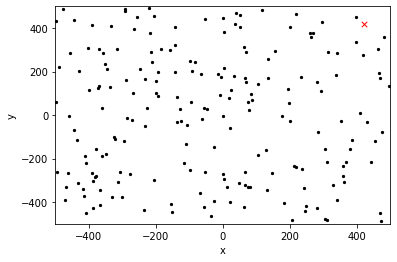

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

def plot_particles(swarm, opt):
    x = [swarm[i].get_pos()[0] for i in range(len(swarm))]
    y = [swarm[i].get_pos()[1] for i in range(len(swarm))]
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(SEARCH_MIN, SEARCH_MAX)
    plt.ylim(SEARCH_MIN, SEARCH_MAX)
    plt.scatter(x, y, c='k', s=5, lw=1)
    plt.scatter(opt[0], opt[1], c='r', marker='x', s=30, lw=1)
    plt.show()
    plt.clf()

plot_particles(SWARM, OPTIMAL_PARTICLE)

Here you can see particles as a black dot and uniformly distributed within the search space and the optimum as a red 'x'. We'll use this function a few more times to visualize how points slowly converge upon the optimum.

## Moving Particles

Particles move within the search space based on the PSO parameters: the inertial weight and social and cognitive coefficients. These should be empirically found for each problem and shouldn't be known a priori but there are a few shortcuts that can be used: some parameter choices have been empirically found to work well if not great for most problems.

Here we'll use some parameters found to be generally great for most problems:

In [7]:
W = 0.729844 # intertial weight
C_1 = 1.496180 # cognitive coefficient
C_2 = 1.496180 # social coefficient

Note `C_1` is equal to `C_2`, giving equivalent import on local exploration/global exploitation and local exploitation/global exploration.

To actually move the particles, we need a way to find the swarm best position:

In [8]:
def get_swarm_best(swarm):
    """Finds the swarm best fitness and position.
    
    Parameters:
        swarm : the swarm to search.
        
    Returns:
        The swarm best fitness and swarm best position.
    """
    # initially assume the first is the best
    best_fit = swarm[0].get_fit()
    best_pos = swarm[0].get_pos()
    for particle in swarm: # for each particle
        # if better fitness found
        if particle.get_fit() < best_fit:
            # update best fitness and position
            best_fit = particle.get_fit()
            best_pos = particle.get_pos()
    return best_fit, best_pos

We can try this out:

In [9]:
def print_best(best):
    print(f'Best position: {best[1]}')
    print(f'Best fitness: {best[0]}')
    
print_best(get_swarm_best(SWARM))

Best position: [397.8972501979873, 453.3622895984888]
Best fitness: 192.09115213681207


Recall the best fitness is $0$, so we have a ways to go. We'll use this function several times when we update our positions. And about updating the positions, it is simply a function of the swarm best position, each particle's best position, their current positions and velocities, and the PSO parameters as defined previously. The math is below:

$$p_i(t+1) = p_i(t) + v_i(t+1)$$

Or, for a dimension $i$, the new position in that dimension is a function of its prior position and new velocity. Here $(t+1)$ means the current iterative step and $t$ is the prior. The new velocity is calculated as:

$$v_i(t+1) = \omega v_i(t) + c_1r_1(y(t) - x_i(t)) + c_2r_2(\hat{y}(t) - x_i(t))$$

Where $\omega$ is the inertial weight, $c_1$ and $c_2$ are the cognitive and social coefficients respectively, $r_1$ and $r_2$ are stochastic multiplicands, and $y$ and $\hat{y}$ is the particle best position and swarm best position respectively. It's useful to think of it split into three separate terms: a weight term ($w$), a cognitive term ($c$) and a social term ($s$):

$$\begin{align}
w &= \omega v_i(t) \nonumber \\
c &= c_1r_1 (y(t) - x_i(t)) \nonumber \\
s &= c_2r_2 (\hat{y}(t) - x_i(t)) \nonumber 
\end{align}$$

Since each term in order deals with the inertial weight, cognitive aspect, and social aspect of the velocity update. The new velocity is simply:

$$v_i(t+1) = w + c + s$$

We'll implement particle movement below:

In [10]:
def move_particles(swarm):
    """Particle movement function.
    
    Parameters:
        swarm : the swarm to move.
    """
    # get swarm bests
    swarm_best = get_swarm_best(swarm)
    for particle in swarm: # for each particle
        # new position and velocity is initially zero
        new_pos = [0 for _ in range(DIMENSIONS)]
        new_vel = [0 for _ in range(DIMENSIONS)]
        for d in range(DIMENSIONS): # for each axis
            # the social and cognitive coefficients 
            # take a stochastic multiplicand
            R_1 = random.uniform(0.00, 1.00)
            R_2 = random.uniform(0.00, 1.00)
            # this is split for readability but the update is based
            # on an addition of a weight, cognitive, and social term
            weight = W * particle.get_vel()[d]
            cognitive = C_1 * R_1
            cognitive *= (particle.get_best_pos()[d] - particle.get_pos()[d])
            social = C_2 * R_2
            social *= (swarm_best[1][d] - particle.get_pos()[d])
            # new velocity is simply weight + cognitive + social
            new_vel[d] = weight + cognitive + social
            # new position is just old position + velocity
            new_pos[d] = particle.get_pos()[d] + new_vel[d]
        # update particle with new position and velocity
        particle.set_pos(new_pos)
        particle.set_vel(new_vel)    

The above function will move particles in a way to reach a better fitness. We can verify that by running it, monitoring the swarm best position and fitness.

In [11]:
print(f'Before movement:')
print_best(get_swarm_best(SWARM))

move_particles(SWARM)

print(f'\nAfter movement:')
print_best(get_swarm_best(SWARM))

Before movement:
Best position: [397.8972501979873, 453.3622895984888]
Best fitness: 192.09115213681207

After movement:
Best position: [428.7136199467444, 437.2562098977089]
Best fitness: 40.811954301692595


Here we can see the swarm best position closes in on the optimal position and the fitness does approach $0$. This is in essence what PSO accomplishes: the algorithm isn't that long or complex and we've pretty much finished. Before I make a main driver for the algorithm, I'll show what the new plot looks like.

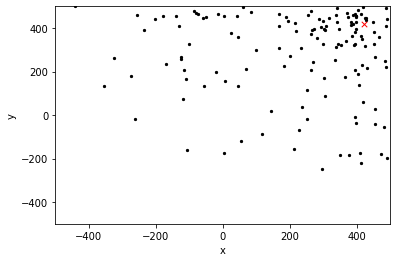

<Figure size 432x288 with 0 Axes>

In [12]:
plot_particles(SWARM, OPTIMAL_PARTICLE)

Here you can see all of the particles have approached the optima to some degree. Were we to run this a few more times, it would get ever more closer. This leads well into our main driver.

## Main Driver

We'll combine everything thus far into one main driver which will move particles over many epochs. It will also output the swarm best fitness as well as what the final plot looks like.

Epoch 0, Best = 159.79625052137567
Epoch 10, Best = 6.791653509486878
Epoch 20, Best = 6.791653509486878
Epoch 30, Best = 0.4872051415511578
Epoch 40, Best = 0.07243380432009872
Epoch 50, Best = 0.021283036086515494
Epoch 60, Best = 0.004067141952418751
Epoch 70, Best = 0.004067141952418751
Epoch 80, Best = 0.0035295543207212177
Epoch 90, Best = 0.00026627935983469797
Epoch 100, Best = 2.6744321985461283e-05


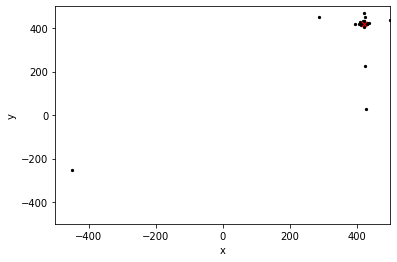

The minimum for the fitness function was found to be 0.00.


<Figure size 432x288 with 0 Axes>

In [13]:
EPOCHS = 100

def pso(dim, epochs):
    """Particle Swarm Optimization driver.
    Initializes the swarm and improves it over time.
    
    Parameters:
        dim : the dimensionality of the problem.
        epochs : how many iterations.
    
    Returns:
        Swarm best fitness after optimizing.
    """
    # initialize the swarm based on problem scope and swarm size
    swarm = initialize_swarm(SWARM_SIZE, dim, SEARCH_MIN, SEARCH_MAX)
    # output initial best fitness
    initial_best = get_swarm_best(swarm)[0]
    print_stats(0, initial_best)
    for e in range(1, epochs+1): # for each iteration
        move_particles(swarm) # move particles to more fit neighborhood
        if e % 10 == 0:
            # every 10th epoch, print new best fitness
            epoch_best = get_swarm_best(swarm)[0]
            print_stats(e, epoch_best)
    # plot the final particles
    plot_particles(swarm, OPTIMAL_PARTICLE)
    # return the swarm best fitness
    return get_swarm_best(swarm)[0]
    
def print_stats(epoch, best):
    print(f'Epoch {epoch}, Best = {best}')

best = pso(DIMENSIONS, EPOCHS)
print(f'The minimum for the fitness function was found to be {best:.2f}.')

Here you can see after a hundred iterations, most of the particles congregate at or around the optimum, our intended behavior. There are a few outliers trapped in local minimum but that's okay. We only particularly care about the swarm best which does find the minimum of the optimization problem.

For fun, here's an animation of a full run-through using the same parameters as above:

<img width="432px" src="./images/animation.gif"/>

Here you see how the swarm does zero in on the optimum. It's quite artistic in a way as it does really simulate something akin to birds converging onto prey.

Other than that, this wraps up the particle swarm optimization tutorial.

## Final Thoughts

Particle swarm optimization can help you find global optima for a fitness function if it's not know a priori or is laborious to find manually. Provided you know the search space and the function to optimize, it's very fast and efficient.

There's a lot more applications to PSO than the trivial example I've used here but since the algorithm is dimensionality and problem agnostic, it can be applied to anything without large changes. It's also a very short algorithm which makes it apt for optimization purposes, at least when compared to something like a genetic algorithm.

Further reading might be on advanced forms of PSO. PSO is good at getting out of local minimum but it's not perfect. Over the years there's been numerous refinements to the algorithm to alleviate this. You can also split swarms into multiple packs (look up Grey Wolf Optimization for something akin to this), try different parameters, or add a local search when particles get trapped in local optima.

## Finished Code

Find below the full uncommented code:

In [ ]:
#!/usr/bin/env python3

from math import sin, sqrt
import random

class Particle:
    def __init__(self, pos, vel):
        self.pos, self.vel = pos, vel
        self.fit = schwefel(self.pos)
        self.best_pos, self.best_fit = self.pos, self.fit

    def set_pos(self, pos):
        self.pos = pos
        if not any(p < SEARCH_MIN for p in pos)\
        and not any(p > SEARCH_MAX for p in pos):
            fitness = schwefel(self.pos)
            if fitness < self.best_fit:
                self.fit = fitness
                self.best_fit = self.fit
                self.best_pos = self.pos

    def set_vel(self, vel):
        self.vel = vel

    def get_pos(self):
        return self.pos

    def get_vel(self):
        return self.vel

    def get_best_pos(self):
        return self.best_pos

    def get_fit(self):
        return self.fit

def pso(dim, epochs):
    swarm = initialize_swarm(SWARM_SIZE, dim, SEARCH_MIN, SEARCH_MAX)
    for e in range(1, epochs+1):
        move_particles(swarm)
    best_fitness = get_swarm_best(swarm)[0]
    print(f'Best minimum found was {best_fitness:.2f}.')

def move_particles(swarm):
    swarm_best = get_swarm_best(swarm)
    for particle in swarm:
        new_pos = [0 for _ in range(DIMENSIONS)]
        new_vel = [0 for _ in range(DIMENSIONS)]
        for d in range(DIMENSIONS):
            R_1 = random.uniform(0.00, 1.00)
            R_2 = random.uniform(0.00, 1.00)
            weight = W * particle.get_vel()[d]
            cognitive = C_1 * R_1
            cognitive *= (particle.get_best_pos()[d] - particle.get_pos()[d])
            social = C_2 * R_2
            social *= (swarm_best[1][d] - particle.get_pos()[d])
            new_vel[d] = weight + cognitive + social
            new_pos[d] = particle.get_pos()[d] + new_vel[d]
        particle.set_pos(new_pos)
        particle.set_vel(new_vel)    

def initialize_swarm(size, dim, min, max):
    swarm = []
    for _ in range(size):
        position = [random.uniform(min, max) for _ in range(dim)]
        velocity = [0 for _ in range(dim)]
        particle = Particle(position, velocity)
        swarm.append(particle)
    return swarm

def get_swarm_best(swarm):
    best_fit = swarm[0].get_fit()
    best_pos = swarm[0].get_pos()
    for particle in swarm:
        if particle.get_fit() < best_fit:
            best_fit = particle.get_fit()
            best_pos = particle.get_pos()
    return best_fit, best_pos

def schwefel(particle):
    summ = 0
    for d in particle:
        summ += d * sin(sqrt(abs(d)))
    return (len(particle) * 418.9829) - summ

if __name__ == '__main__':
    SEARCH_MIN = -500
    SEARCH_MAX = 500
    DIMENSIONS = 2
    SWARM_SIZE = 200
    EPOCHS = 100
    W = 0.729844
    C_1 = 1.496180
    C_2 = 1.496180
    pso(DIMENSIONS, EPOCHS)

You may wish to catch for errors (as I have done none here), and perhaps accept some of the parameters as command line arguments. This code, as-is, should run in a terminal but allows for zero customization unless you change the code manually. Some parameters might include inertial weight and cognitive/social coefficients, swarm size, how many epochs, etc.

You can save this code as `particle_algorithm.py` and execute it as one of the below:

```
$ python3 particle_algorithm.py
$ ./particle_algorithm.py
```

You can also find the code in `./code`. For a C++ implementation I did for optimizing the Rastrigin function, you can see it <a href="https://github.com/stratzilla/pso-rastrigin">here</a>.
